# Business Case: Analyzing the Impact of Remote Work on Employee Productivity

### Background:

With the increasing remote work trend, OptimaTech Solutions is interested in understanding its impact on employee productivity. There is a hypothesis that remote work leads to increased or decreased productivity due to factors like work environment, work-life balance, and communication efficiency.

### Objective:

## You must conduct a causality analysis to understand the impact of remote work on employee productivity. The analysis should consider various confounding variables that might affect the adoption of remote work and employee productivity.

### Data Provided:

    •	Employee demographic data
    •	Information on their work arrangement
    •	Productivity metrics (could be based on project delivery time, quality of work, etc.)
    •	Employee engagement scores
    •	Employee performance
    •	Data on team communication patterns (frequency, medium, etc.)

### Tasks:

    •	Describe your causal model to describe the relationships between remote work and employee productivity, including other factors that may influence this relationship.
    •	Data Analysis: Using the provided data, perform statistical analysis to estimate the causal effect of remote work on productivity. This should include data preprocessing, handling missing data, and any necessary statistical tests or models.
    •	Calculate the effect of remote work on productivity and conduct sensitivity analysis to check how robust the findings are.
    •	Report Findings: Prepare a presentation communicating the methodology, analysis, and findings. The presentation should be understandable to both technical and non-technical stakeholders.
    •	Recommendations: Based on the findings, provide actionable recommendations for the company regarding remote work policies.

### Deliverables:

    •	A detailed report (ex. Jupyter Notebook) including the causal model, methodology, analysis, and findings.
    •	A presentation summarizing the key aspects of the research and recommendations.
    •	Evaluation Criteria:
    •	Accuracy and relevance of the causal model.
    •	Appropriateness of the statistical methods and models used.
    •	Clarity and effectiveness of communication in both the report and the presentation.
    •	Practicality and innovativeness of the recommendations.


### Import Libraries


In [1]:
import os
os.getcwd()

import numpy as np  
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy import stats
from scipy.stats import shapiro
from scipy.stats import chisquare


import statsmodels.api as sm


import warnings

import seaborn as sns
import matplotlib.pyplot as plt   
import matplotlib.style

warnings.filterwarnings('ignore')

%matplotlib inline



### Load Data and carry out hygiene checks


In [2]:

# Load the dataset
df = pd.read_excel('synthetic_people_analytics_data_excel.xlsx')
df.shape

(1000, 13)

In [3]:
df.head()

,Employee ID,Age,Gender,Department,Tenure (Years),Remote Work Status,Engagement Score,Communication Frequency,Distance from Office (km),Marital Status,Number of Children,Productivity Score,Employee Performance
0,1,45,M,IT,7,On-site,6.889742,Medium,28,Divorced,4,74.661634,49.488918
1,2,47,F,R&D,1,Hybrid,4.167739,Low,25,Divorced,3,71.838682,59.914017
2,3,28,F,Marketing,15,Remote,9.959449,Medium,16,Divorced,0,83.345036,61.362653
3,4,55,F,HR,13,Hybrid,2.970830,High,31,Single,3,49.964142,57.813307
4,5,50,F,Marketing,15,On-site,2.671661,Low,17,Single,4,53.233881,46.864275


In [4]:
df.isnull().sum()

Employee ID                  0
Age                          0
Gender                       0
Department                   0
Tenure (Years)               0
Remote Work Status           0
Engagement Score             0
Communication Frequency      0
Distance from Office (km)    0
Marital Status               0
Number of Children           0
Productivity Score           0
Employee Performance         0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Employee ID                1000 non-null   int64  
 1   Age                        1000 non-null   int64  
 2   Gender                     1000 non-null   object 
 3   Department                 1000 non-null   object 
 4   Tenure (Years)             1000 non-null   int64  
 5   Remote Work Status         1000 non-null   object 
 6   Engagement Score           1000 non-null   float64
 7   Communication Frequency    1000 non-null   object 
 8   Distance from Office (km)  1000 non-null   int64  
 9   Marital Status             1000 non-null   object 
 10  Number of Children         1000 non-null   int64  
 11  Productivity Score         1000 non-null   float64
 12  Employee Performance       1000 non-null   float64
dtypes: float64(3), int64(5), object(5)
memory usage: 

In [6]:
pd.DataFrame(df[df.duplicated()].count(), columns = ['Number of duplicate rows'])

,Number of duplicate rows
Employee ID,0
Age,0
Gender,0
Department,0
Tenure (Years),0
Remote Work Status,0
Engagement Score,0
Communication Frequency,0
Distance from Office (km),0
Marital Status,0


In [7]:
df.drop('Employee ID', axis = 1, inplace = True)
df['Number of Children'] = df['Number of Children'].astype(str)

### Data Review

### Insights

- Employee ID is an identifier and not relevant in our causal analysis
- Number of Children though being integer is not a continuous variable and has to be treated as a categorical variable
- Only Employee Performance is normally distributed. 
- Productivity Score has a co-efficient fo variation of 16% implying that scores do not vary too much and are centred around the mean.





### Insights
    - Employee ID is an identifier and not relevant in our causal analysis
    - Number of Children though being integer is not a continuous variable and has to be treated as a categorical variable
    - Only Employee Performance is normally distributed
    - All categorical variables are uniformly distributed
    - Continuous Variables (Employee Performance, Engagement Score), (Employee Performance, Productivity Score), (Engagement Score, Productivity Score) show a clear relationship between each other
    - Treatment Variable i.e. Remote Work Status shows clear difference in Productivity Score values for each of the category





In [8]:
pd.set_option('display.float_format', '{:.2f}'.format)

temp1 = df.select_dtypes(include=np.number).columns.tolist()
temp2 = df.select_dtypes('object').columns.tolist()

temp3 = {}
for i in temp1:
    temp3[i] = df[i].skew()
temp3 = pd.DataFrame(temp3, index = ['Skewness'])

temp4 = {}
for i in temp1:
    temp4[i] = df[i].kurtosis()
temp4 = pd.DataFrame(temp4, index = ['Kurtosis'])

temp5= pd.DataFrame(df.describe())

summary = pd.concat([temp3,temp4, temp5]).T
summary['Co-efficient of Variation'] = (summary['std']/summary['mean'])
summary['count'] = summary['count'].astype(int).round(decimals = 2)
summary.iloc[:-1,:]

,Skewness,Kurtosis,count,mean,std,min,25%,50%,75%,max,Co-efficient of Variation
Age,0.02,-1.14,1000,42.75,11.94,22.00,33.00,43.00,53.00,64.00,0.28
Tenure (Years),-0.00,-1.20,1000,9.98,5.42,1.00,5.00,10.00,14.25,19.00,0.54
Engagement Score,0.06,-1.16,1000,5.42,2.57,1.01,3.17,5.37,7.62,10.00,0.48
Distance from Office (km),0.02,-1.17,1000,24.67,14.09,1.00,12.00,25.00,36.00,49.00,0.57
Productivity Score,0.01,-0.45,1000,66.26,10.30,36.18,58.74,65.84,73.72,92.06,0.16


In [9]:
df.describe(include = 'object').T

,count,unique,top,freq
Gender,1000,2,M,529
Department,1000,5,HR,216
Remote Work Status,1000,3,Hybrid,343
Communication Frequency,1000,3,Medium,354
Marital Status,1000,3,Married,355
Number of Children,1000,5,2,221


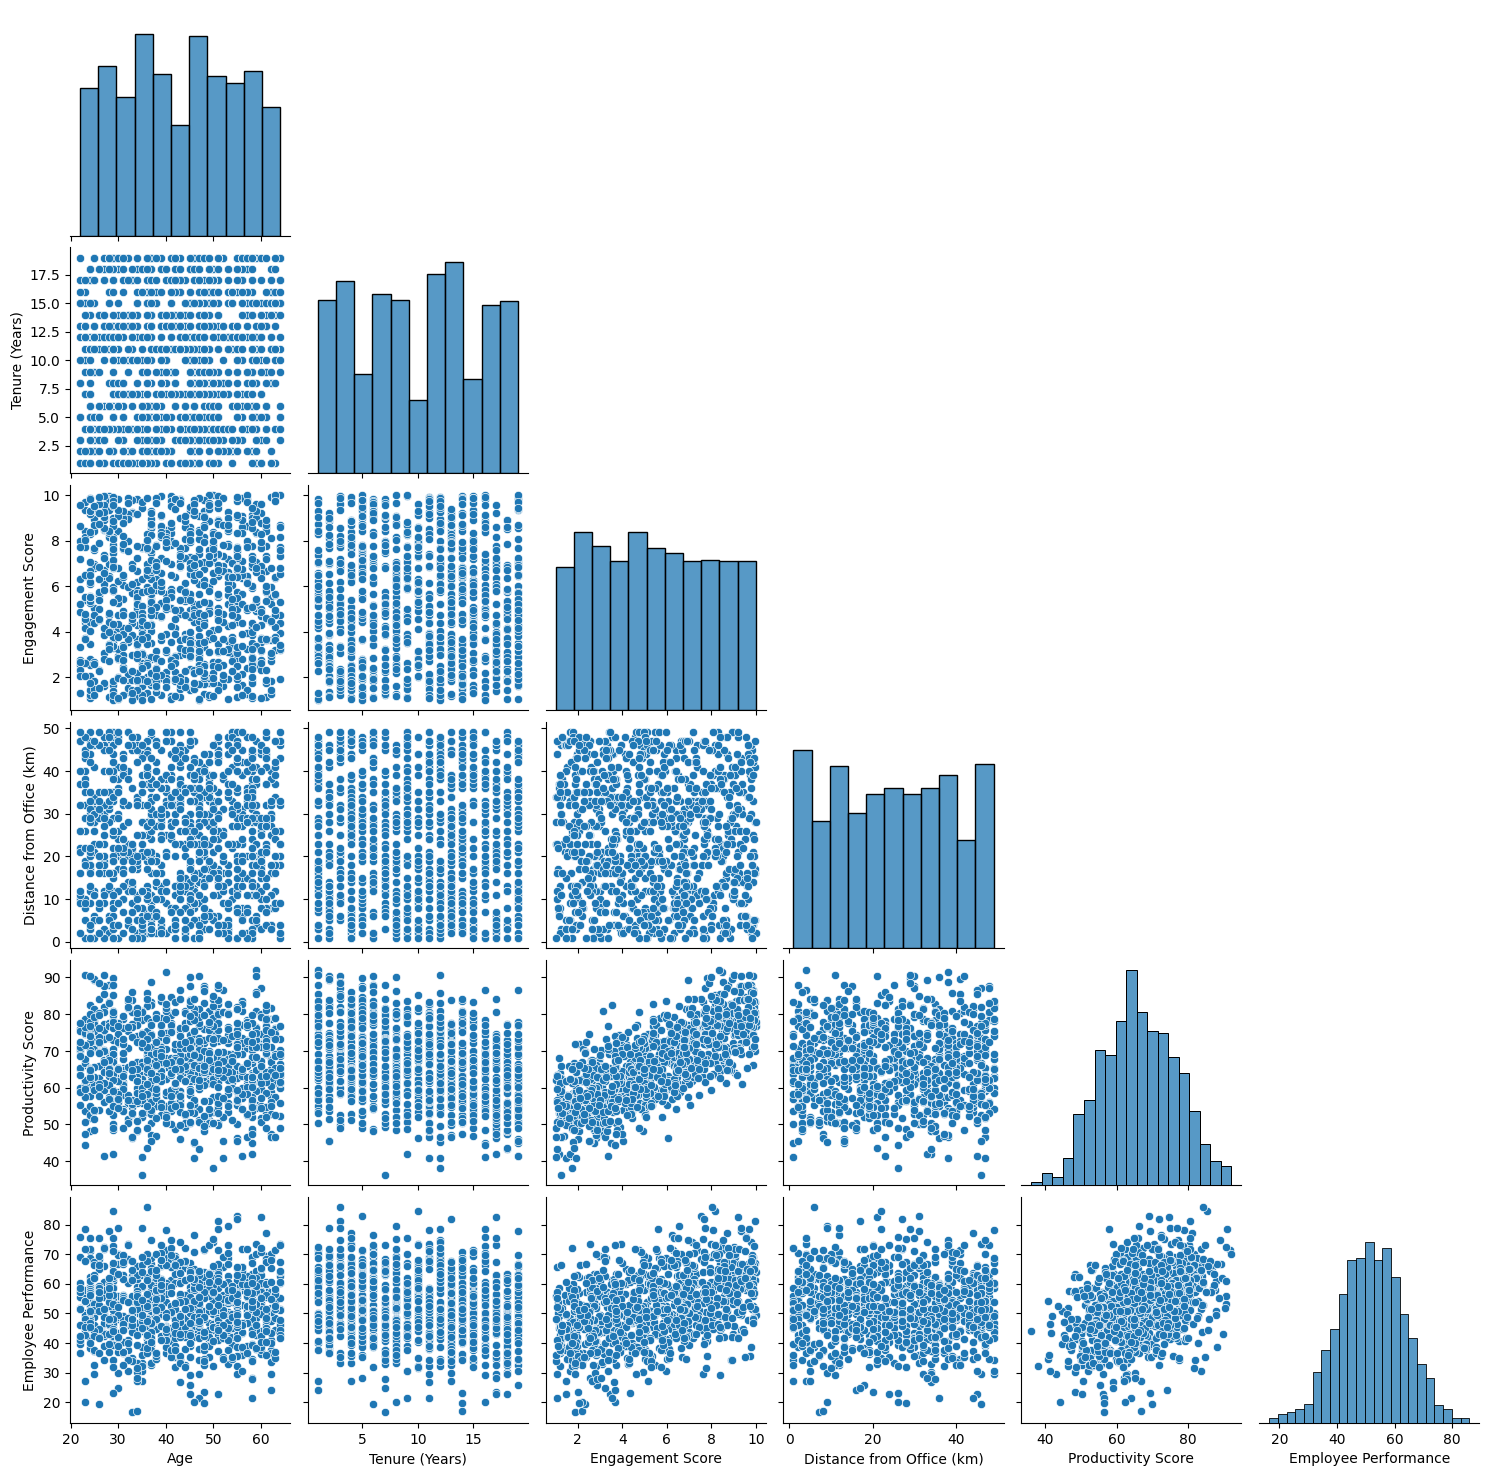

In [10]:
sns.pairplot(df, corner = True)

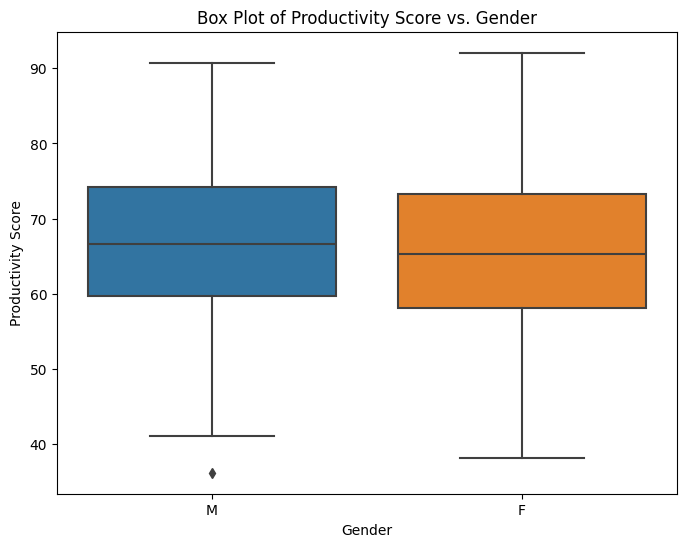

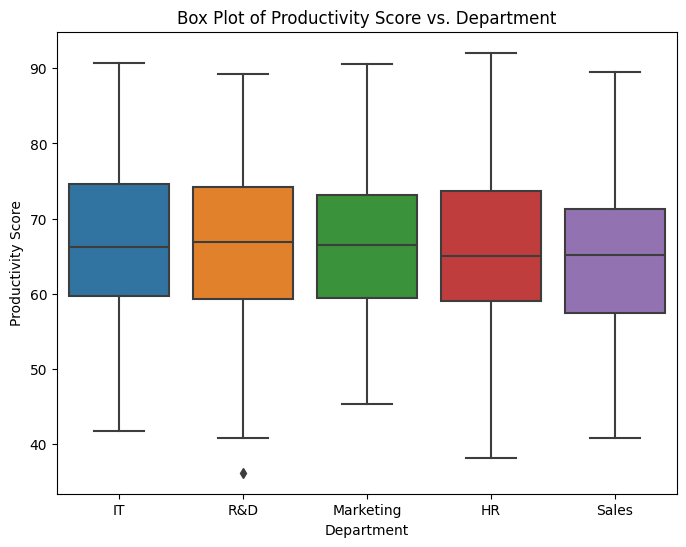

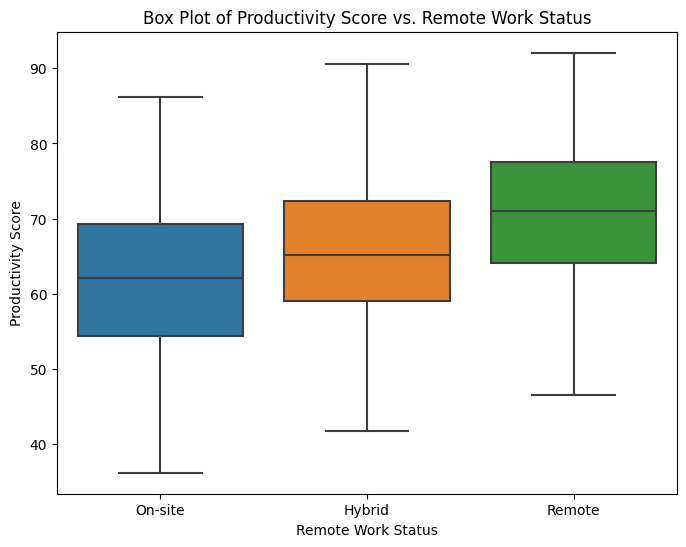

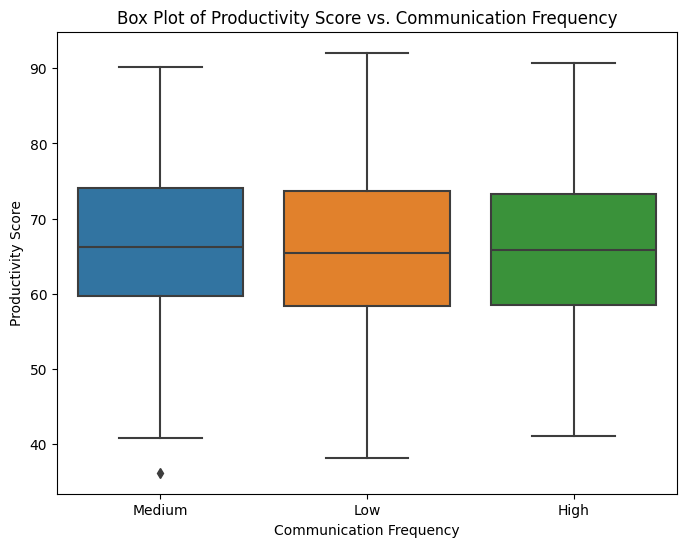

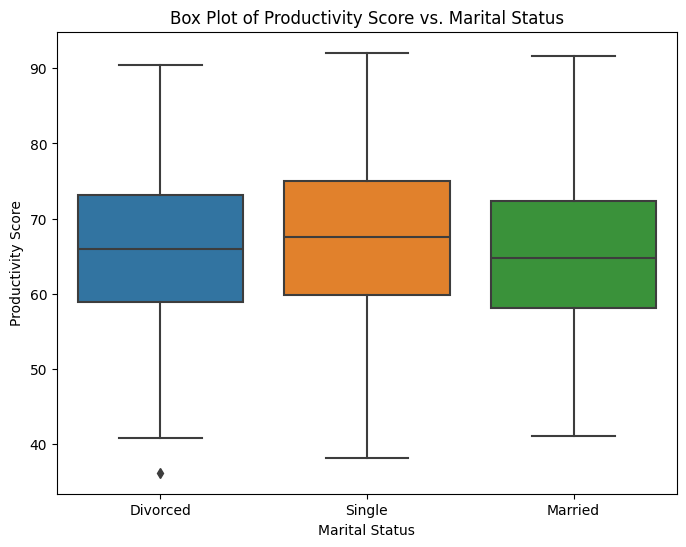

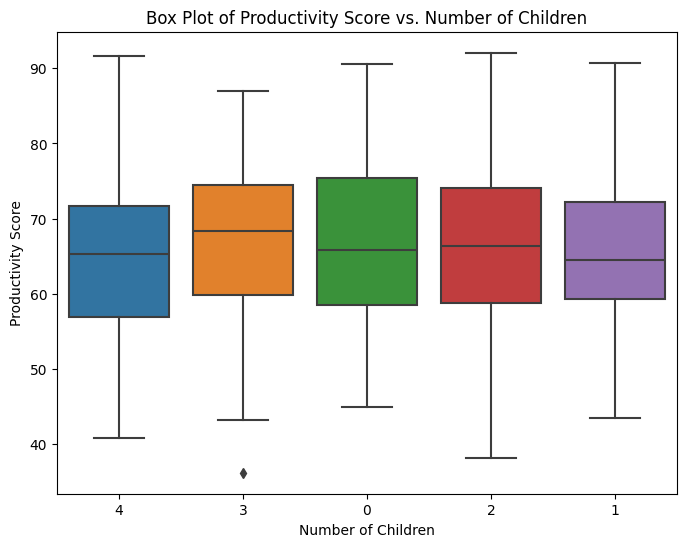

In [11]:
import seaborn as sns

for column in df.select_dtypes(exclude=['number']):
    plt.figure(figsize=(8, 6))
    sns.boxplot(y=df['Productivity Score'], x=df[column])
    plt.title(f'Box Plot of Productivity Score vs. {column}')
    plt.xlabel(column)
    plt.ylabel('Productivity Score')
    plt.show()

### Check whether continuous variables are normally distributed

In [12]:
from scipy.stats import shapiro
shapiro_results = {}
for column in df.select_dtypes(include=np.number).columns[1:]:
    stat, p = shapiro(df[column])
    shapiro_results[column] = {'Statistic': stat, 'p-value': p}
    
    if p < 0.05:
        print(f' {column} is not normally distributed')
    else:
        print(f'====== {column} is normally distributed ====')


 Tenure (Years) is not normally distributed
 Engagement Score is not normally distributed
 Distance from Office (km) is not normally distributed
 Productivity Score is not normally distributed
====== Employee Performance is normally distributed ====


### Check whether categorical variables are uniformly distributed

In [13]:
from scipy.stats import chisquare

for i in df.select_dtypes(exclude = np.number):
    observed_counts =  df[i].value_counts().tolist()
    expected_counts = [sum(observed_counts) / len(observed_counts)] * len(observed_counts)
    chi_stat, p = chisquare(observed_counts, f_exp=expected_counts)

    if p < 0.05:
        print(f'======{i} is not uniformly distributed with p-value of {p} ======')
    else:
        print(f'{i} is uniformly distributed with p-value of {p}')




Gender is uniformly distributed with p-value of 0.06663602844578971
Department is uniformly distributed with p-value of 0.8033903791608523
Remote Work Status is uniformly distributed with p-value of 0.7139088399027201
Communication Frequency is uniformly distributed with p-value of 0.2833705142530199
Marital Status is uniformly distributed with p-value of 0.26527188442244004
Number of Children is uniformly distributed with p-value of 0.16353457555477177


### Data Transformation
1. One-Hot Encode Categorical Variables
2. Standardize continuous variables for reducing scale effects

In [14]:
df.select_dtypes(exclude = 'object').columns.tolist()

['Age',
 'Tenure (Years)',
 'Engagement Score',
 'Distance from Office (km)',
 'Productivity Score',
 'Employee Performance']

In [15]:
categorical_columns = df.select_dtypes(exclude = np.number).columns.tolist()
numerical_columns = df.select_dtypes(exclude = 'object').columns.tolist()
numerical_columns.remove('Productivity Score')

categorical_transformer = OneHotEncoder(drop='first')
numerical_transformer = StandardScaler()

transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

data_trf = transformer.fit_transform(df)

trf_columns = (numerical_columns + list(transformer.named_transformers_['cat'].get_feature_names_out(categorical_columns)))

df_trf = pd.DataFrame(data_trf, columns=trf_columns)

df_trf = pd.concat([df_trf, df['Productivity Score']], axis = 1)

df1 = df_trf.copy()
print(df1.shape)
df1.columns = df1.columns.str.replace(' ', '_', regex=True)
df1.columns

(1000, 21)


Index(['Age', 'Tenure_(Years)', 'Engagement_Score',
       'Distance_from_Office_(km)', 'Employee_Performance', 'Gender_M',
       'Department_IT', 'Department_Marketing', 'Department_R&D',
       'Department_Sales', 'Remote_Work_Status_On-site',
       'Remote_Work_Status_Remote', 'Communication_Frequency_Low',
       'Communication_Frequency_Medium', 'Marital_Status_Married',
       'Marital_Status_Single', 'Number_of_Children_1', 'Number_of_Children_2',
       'Number_of_Children_3', 'Number_of_Children_4', 'Productivity_Score'],
      dtype='object')

# Modelling

## Using Causal Model from dowhy

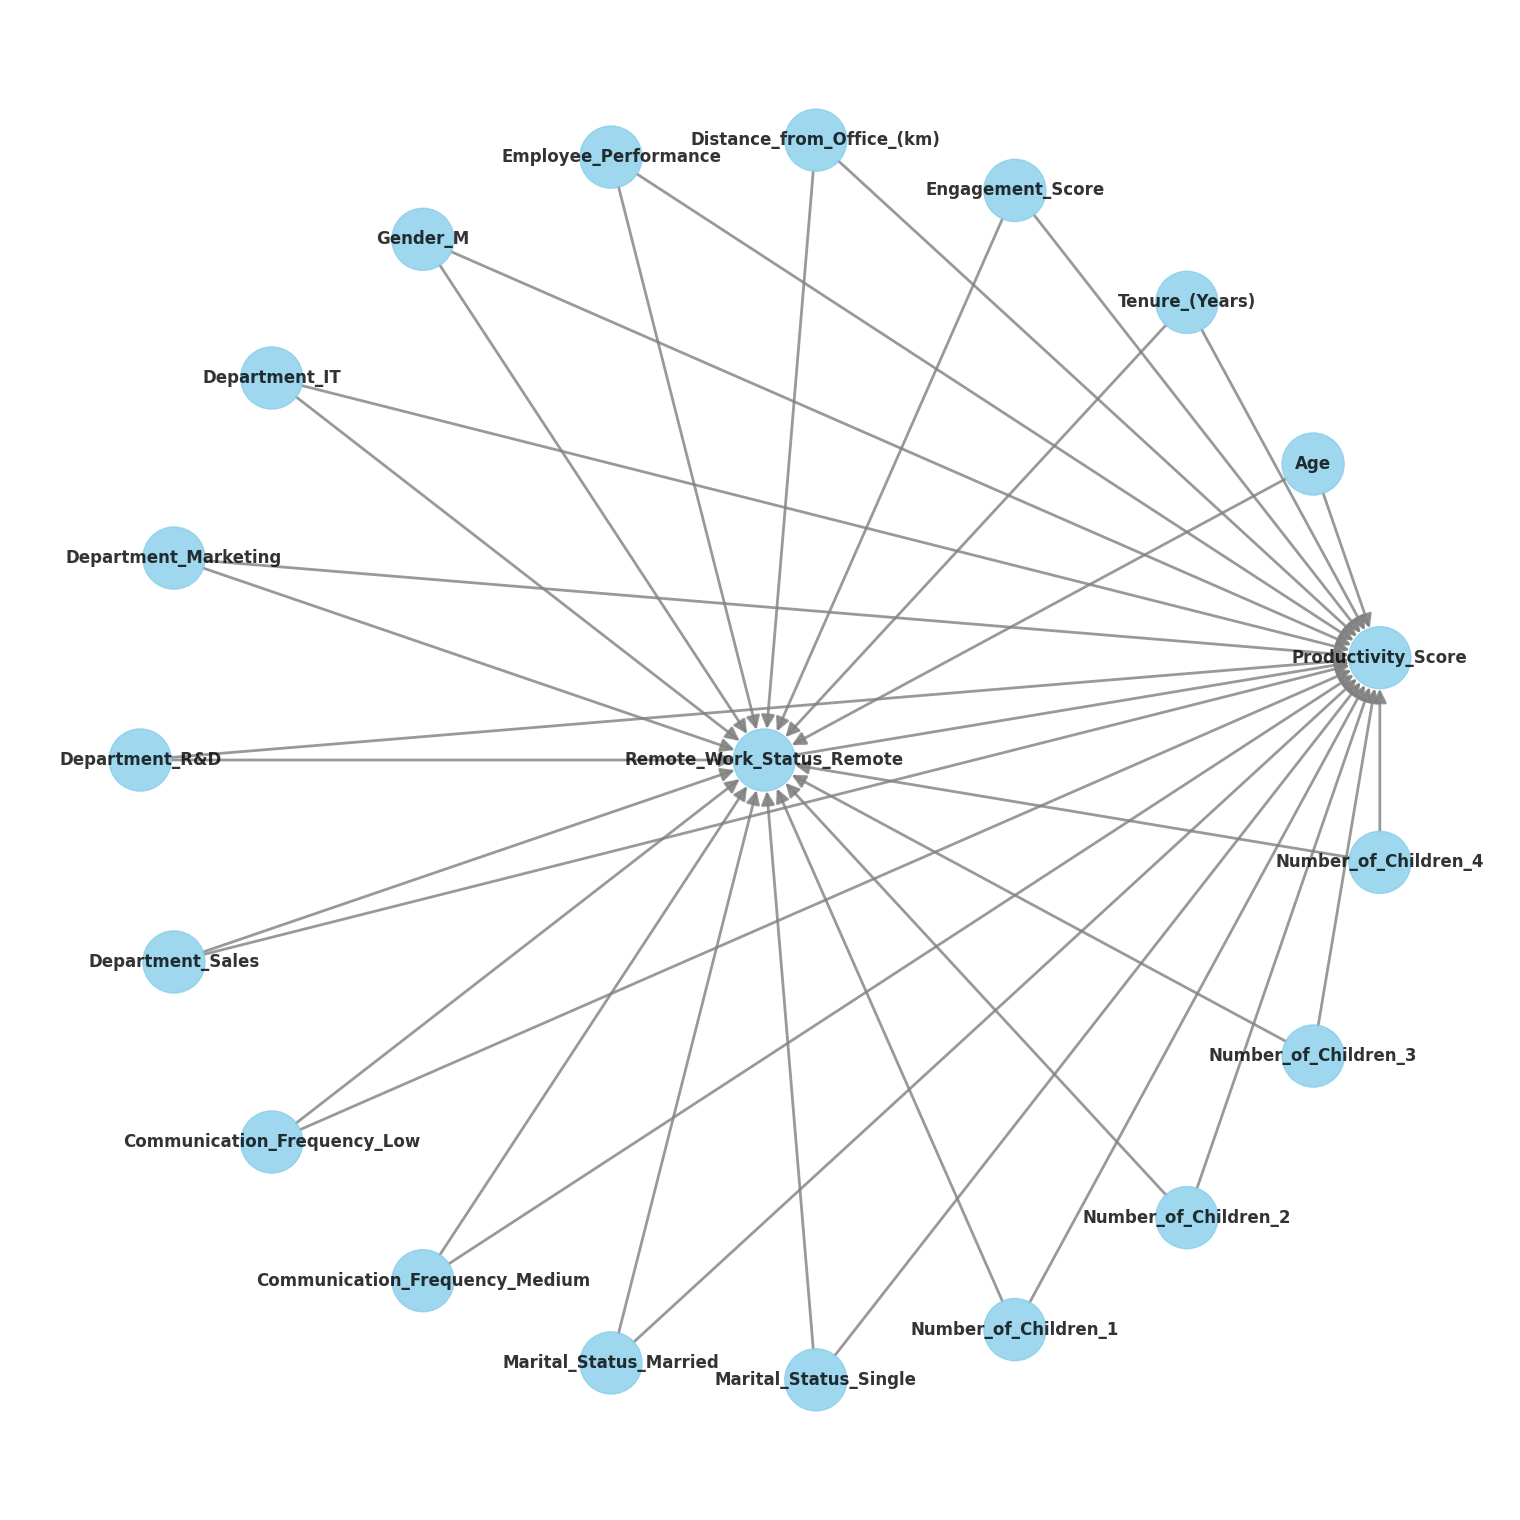

estimate based on propensity score matching: 7.139864607206587
estimate based on linear regression: 7.12017784566558
Refute: Add a random common cause
Estimated effect:7.139864607206587
New effect:7.13986460720659
p value:1.0

Refute: Use a subset of data
Estimated effect:7.139864607206587
New effect:7.127307097658701
p value:0.96



In [16]:
# Import the model
import dowhy
from dowhy import CausalModel
from IPython.display import Image, display

# For the causal model, we need to define our treatment, outcome, and confounders.
# Based on the EDA and the nature of the data, let's define these components.

# Treatment: Remote Work Status (binary, where 1 represents remote work)
treatment = 'Remote_Work_Status_Remote'

# Outcome: Productivity Score
outcome = 'Productivity_Score'

# Confounders: Include variables that could influence both the adoption of remote work and the productivity score. 
# We'll include demographics, work arrangement specifics, and engagement scores.

confounders = ['Age',
 'Tenure_(Years)',
 'Engagement_Score',
 'Distance_from_Office_(km)',
 'Employee_Performance',
 'Gender_M',
 'Department_IT',
 'Department_Marketing',
 'Department_R&D',
 'Department_Sales',
 'Communication_Frequency_Low',
 'Communication_Frequency_Medium',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Number_of_Children_1',
 'Number_of_Children_2',
 'Number_of_Children_3',
 'Number_of_Children_4']


# Constructing the causal model
causal_model = CausalModel(
    data=df1,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders
)

# Visualizing the causal model to understand the specified relationships
# causal_graph = causal_model.view_model()
# display(Image(data=causal_graph.encode('causal_model.png')))
causal_model.view_model(layout="twopi", size = (15,15))

# Now, let's identify the causal effect using DoWhy
identified_estimand = causal_model.identify_effect()


# Estimating the causal effect based on the identified estimand and the backdoor criterion of propensity score matching
estimate = causal_model.estimate_effect(identified_estimand,
                                        method_name="backdoor.propensity_score_matching")
print(f'estimate based on propensity score matching: {estimate.value}')

# Estimating the causal effect based on the identified estimand and the backdoor criterion of linear regression
estimate_r = causal_model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression")
print(f'estimate based on linear regression: {estimate_r.value}')


# Random Common Cause
refutation = causal_model.refute_estimate(identified_estimand, estimate,
                                          method_name="random_common_cause")
print(refutation)


# Data Subset Refuter
refutation = causal_model.refute_estimate(identified_estimand, estimate,
                                          method_name="data_subset_refuter")
print(refutation)


In [17]:
print(causal_model.identify_effect(proceed_when_unidentifiable=True))

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                
────────────────────────────(E[Productivity_Score|Age,Number_of_Children_3,Com
d[Remote_Work_Status_Remote]                                                  

                                                                              
munication_Frequency_Low,Distance_from_Office_(km),Communication_Frequency_Med
                                                                              

                                                                              
ium,Employee_Performance,Engagement_Score,Number_of_Children_2,Number_of_Child
                                                                              

                                                                              
ren_1,Department_Sales,Tenure_(Years),Marital_Status_Married,Department_R&D,Ma
                   

In [18]:
df1.columns

Index(['Age', 'Tenure_(Years)', 'Engagement_Score',
       'Distance_from_Office_(km)', 'Employee_Performance', 'Gender_M',
       'Department_IT', 'Department_Marketing', 'Department_R&D',
       'Department_Sales', 'Remote_Work_Status_On-site',
       'Remote_Work_Status_Remote', 'Communication_Frequency_Low',
       'Communication_Frequency_Medium', 'Marital_Status_Married',
       'Marital_Status_Single', 'Number_of_Children_1', 'Number_of_Children_2',
       'Number_of_Children_3', 'Number_of_Children_4', 'Productivity_Score',
       'propensity_score'],
      dtype='object')

## Insights from Causal Model

1. Remote Work has a positive impact on productivity
2. Backdoor methods  have been carried out to ensure that the output is reliable
3. We have assumed that there is no Omitted Variable Bias. On, performing Linear Regression, we see adjusted R squared of 0.77 approx implying there are additional factors that have not been included and that can impact Productivity Score
4. Different robustness checks (including random cause or using subset of data) show that the causal effect of Remote_Work_Status_Remote on productivity remains stable and does not change significantly


# Using Linear Regression Approach

In [19]:
ind_vars = ['Age',
 'Tenure_(Years)',
 'Engagement_Score',
 'Distance_from_Office_(km)',
 'Employee_Performance',
 'Gender_M',
 'Department_IT',
 'Department_Marketing',
 'Department_R&D',
 'Department_Sales',
 'Remote_Work_Status_On-site',
 'Remote_Work_Status_Remote',
 'Communication_Frequency_Low',
 'Communication_Frequency_Medium',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Number_of_Children_1',
 'Number_of_Children_2',
 'Number_of_Children_3',
 'Number_of_Children_4']
len(ind_vars)

In [20]:
covariates = ['Age',
 'Tenure_(Years)',
 'Engagement_Score',
 'Distance_from_Office_(km)',
 'Employee_Performance',
 'Gender_M',
 'Department_IT',
 'Department_Marketing',
 'Department_R&D',
 'Department_Sales',
 'Communication_Frequency_Low',
 'Communication_Frequency_Medium',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Number_of_Children_1',
 'Number_of_Children_2',
 'Number_of_Children_3',
 'Number_of_Children_4',]
len(covariates)

### Evaluating relationship of independent variables on Productivity Score. We have dropped employee id as it is an identifier variable.

In [21]:
X = df1[ind_vars]
y = df1['Productivity_Score'] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     Productivity_Score   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     165.5
Date:                Wed, 28 Feb 2024   Prob (F-statistic):          4.28e-297
Time:                        17:14:26   Log-Likelihood:                -3011.5
No. Observations:                1000   AIC:                             6065.
Df Residuals:                     979   BIC:                             6168.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

### Evaluating relationship of confounders with Productivity Score

In [22]:
X = df1[covariates]
y = df1['Productivity_Score'] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     Productivity_Score   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     93.51
Date:                Wed, 28 Feb 2024   Prob (F-statistic):          3.38e-198
Time:                        17:14:26   Log-Likelihood:                -3250.6
No. Observations:                1000   AIC:                             6539.
Df Residuals:                     981   BIC:                             6632.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

### Evaluating relationship of Remote Work Status with Productivity Score (excluding confounders)

In [23]:
X = df1[['Remote_Work_Status_Remote', 'Remote_Work_Status_On-site']]
y = df1['Productivity_Score'] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Productivity_Score   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     68.46
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           1.38e-28
Time:                        17:14:26   Log-Likelihood:                -3685.8
No. Observations:                1000   AIC:                             7378.
Df Residuals:                     997   BIC:                             7392.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

### Evaluating relationship of Remote Work Status being "Remote" on Productivity Score

In [24]:
X = df1['Remote_Work_Status_Remote']
y = df1['Productivity_Score'] 
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Productivity_Score   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     109.5
Date:                Wed, 28 Feb 2024   Prob (F-statistic):           2.23e-24
Time:                        17:14:27   Log-Likelihood:                -3698.1
No. Observations:                1000   AIC:                             7400.
Df Residuals:                     998   BIC:                             7410.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [25]:
df1.columns

Index(['Age', 'Tenure_(Years)', 'Engagement_Score',
       'Distance_from_Office_(km)', 'Employee_Performance', 'Gender_M',
       'Department_IT', 'Department_Marketing', 'Department_R&D',
       'Department_Sales', 'Remote_Work_Status_On-site',
       'Remote_Work_Status_Remote', 'Communication_Frequency_Low',
       'Communication_Frequency_Medium', 'Marital_Status_Married',
       'Marital_Status_Single', 'Number_of_Children_1', 'Number_of_Children_2',
       'Number_of_Children_3', 'Number_of_Children_4', 'Productivity_Score',
       'propensity_score'],
      dtype='object')

In [26]:
df1.to_csv('Transformed.csv')

## Causal Model - A two world Approach

## Method 1

### Performing Propensity Score Matching

In [27]:
covariates

['Age',
 'Tenure_(Years)',
 'Engagement_Score',
 'Distance_from_Office_(km)',
 'Employee_Performance',
 'Gender_M',
 'Department_IT',
 'Department_Marketing',
 'Department_R&D',
 'Department_Sales',
 'Communication_Frequency_Low',
 'Communication_Frequency_Medium',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Number_of_Children_1',
 'Number_of_Children_2',
 'Number_of_Children_3',
 'Number_of_Children_4']

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

covariates = ['Age',
 'Tenure_(Years)',
 'Engagement_Score',
 'Distance_from_Office_(km)',
 'Employee_Performance',
 'Gender_M',
 'Department_IT',
 'Department_Marketing',
 'Department_R&D',
 'Department_Sales',
 'Communication_Frequency_Low',
 'Communication_Frequency_Medium',
 'Marital_Status_Married',
 'Marital_Status_Single',
 'Number_of_Children_1',
 'Number_of_Children_2',
 'Number_of_Children_3',
 'Number_of_Children_4']

X = df1[covariates]
y = df1['Remote_Work_Status_Remote']

logit = LogisticRegression()
logit.fit(X, y)
propensity_scores = logit.predict_proba(X)[:, 1]

df1['propensity_score'] = propensity_scores

def match_with_nearest_propensity_score(df, treatment_col, score_col):
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    distances = cdist(treated[[score_col]].values, control[[score_col]].values, metric='euclidean')
    nn = np.argmin(distances, axis=1)
    matched = control.iloc[nn].reset_index(drop=True)
    return treated.reset_index(drop=True), matched

treated_df, matched_control_df = match_with_nearest_propensity_score(df1, treatment_col='Remote_Work_Status_Remote', score_col='propensity_score')

print(treated_df.shape)
print(matched_control_df.shape)



(335, 22)
(335, 22)


In [29]:
# Assuming 'Productivity_Score' is the outcome variable of interest
# Calculate the mean productivity score for both the treated and matched control groups
mean_productivity_treated = treated_df['Productivity_Score'].mean()
mean_productivity_control = matched_control_df['Productivity_Score'].mean()

# Calculate the Average Treatment Effect on the Treated (ATT)
ATE = mean_productivity_treated - mean_productivity_control

# Calculate the average outcome in both the treated and matched control groups
average_outcome_treated = treated_df['Productivity_Score'].mean()
average_outcome_control = matched_control_df['Productivity_Score'].mean()

# Calculate the Average Treatment Effect (ATE)
ate = average_outcome_treated - average_outcome_control

print(f"Average Outcome in Treated Group: {average_outcome_treated:.3f}")
print(f"Average Outcome in Control Group: {average_outcome_control:.3f}")
print(f"Estimated Average Treatment Effect (ATE) of Remote Work on Productivity: {ate:.3f}")

Average Outcome in Treated Group: 70.822
Average Outcome in Control Group: 63.964
Estimated Average Treatment Effect (ATE) of Remote Work on Productivity: 6.858


In [30]:
from scipy.stats import ttest_ind

# Conduct a t-test to assess the significance of the difference in means
t_stat, p_value = ttest_ind(treated_df['Productivity_Score'], matched_control_df['Productivity_Score'])

print(f"T-statistic: {t_stat}, P-value: {p_value}")


T-statistic: 8.889580904934597, P-value: 5.6666946072208584e-18


In [31]:
import numpy as np
from scipy import stats

std_treated = np.std(treated_df['Productivity_Score'])
std_control = np.std(matched_control_df['Productivity_Score'])

n_treated = len(treated_df)
n_control = len(matched_control_df)

se = np.sqrt((std_treated**2 / n_treated) + (std_control**2 / n_control))

ci = stats.norm.interval(0.95, loc=6.858, scale=se)

print(f"95% Confidence Interval: {ci}")


95% Confidence Interval: (5.348213203978046, 8.367786796021953)


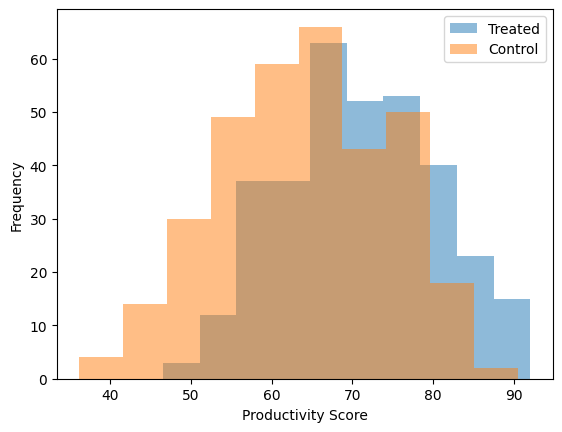

In [32]:
import matplotlib.pyplot as plt

plt.hist(treated_df['Productivity_Score'], alpha=0.5, label='Treated')
plt.hist(matched_control_df['Productivity_Score'], alpha=0.5, label='Control')
plt.xlabel('Productivity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Counterfactual Test

In [33]:
# Import the model
import pandas as pd
import numpy as np
import dowhy
from dowhy import CausalModel
from IPython.display import Image, display

print(df1.shape)
df2 = df1.copy()
df2.drop(['Remote_Work_Status_On-site', 'propensity_score'],axis = 1, inplace = True)
print(df2.shape)

# Constructing the causal model
causal_model = CausalModel(
    data=df2,
    treatment=treatment,
    outcome=outcome,
    common_causes=confounders
)

identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

method = "backdoor.linear_regression"

desired_effect = "ate"

estimate = causal_model.estimate_effect(
    identified_estimand,
    method_name=method,
    target_units=desired_effect,                         
    method_params={"weighting_scheme":"ips_weight"})

print("Causal Estimate is " + str(estimate.value))
treatment_value_treated = 1
treatment_value_control = 0
treatment_col = 'Remote_Work_Status_Remote'
outcome_col = 'Productivity_Score'

df_cf_control = df2.copy()
df_cf_control['Remote_Work_Status_Remote'] = 0
df_cf_treated = df2.copy()
df_cf_treated['Remote_Work_Status_Remote'] = 1

cf_estimate_control = estimate.estimator.predict(
    data_df=df_cf_control,
)
print(f'Mean outcome if all control [all participants] if Status is set as Non-Remote for all cases: {cf_estimate_control.mean()}')

cf_estimate_treated = estimate.estimator.predict(
    data_df=df_cf_treated,
)
print(f'Mean outcome if all treated [all participants] if Status is set as Remote for all cases: {cf_estimate_treated.mean()}')


(1000, 22)
(1000, 20)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
             d                                                                
────────────────────────────(E[Productivity_Score|Age,Number_of_Children_3,Com
d[Remote_Work_Status_Remote]                                                  

                                                                              
munication_Frequency_Low,Distance_from_Office_(km),Communication_Frequency_Med
                                                                              

                                                                              
ium,Employee_Performance,Engagement_Score,Number_of_Children_2,Number_of_Child
                                                                              

                                                                              
ren_1,Department_Sales,Tenure_(Years),Marital_Status_Married,Department_R&D,Ma
                   